In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
  import napari


# Install dependencies
! pip install --upgrade pip
! pip install czitools
! pip install ipyfilechooser

In [2]:
# import the required libraries
from czitools import metadata_tools as czimd
from czitools import read_tools as czird
from czitools import misc_tools
from ipyfilechooser import FileChooser
from IPython.display import display, HTML
from pathlib import Path
import os
import dask.array as da

if not IN_COLAB:
    from czitools import napari_tools


In [ ]:
# Folder containing the input data
INPUT_FOLDER = 'data/'

# Path to the data on GitHub
GITHUB_IMAGES_PATH = "https://raw.githubusercontent.com/sebi06/czitools/main/data.zip"

# Download data
if not (os.path.isdir(INPUT_FOLDER)):
    compressed_data = './data.zip'
    if not os.path.isfile(compressed_data):
        import io
        response = requests.get(GITHUB_IMAGES_PATH, stream=True)
        compressed_data = io.BytesIO(response.content)

    import zipfile
    with zipfile.ZipFile(compressed_data, 'r') as zip_accessor:
        zip_accessor.extractall('./')

In [3]:
fc = FileChooser(INPUT_FOLDER)
fc.filter_pattern = '*.czi'
display(fc)

FileChooser(path='F:\Github\czitools\data', filename='', title='', show_hidden=False, select_desc='Select', ch…

In [4]:
# Print the selected path, filename, or both
print(fc.selected_path)
print(fc.selected_filename)
print(fc.selected)

F:\Github\czitools\data
CellDivision_T=3_Z=5_CH=2_X=240_Y=170.czi
F:\Github\czitools\data\CellDivision_T=3_Z=5_CH=2_X=240_Y=170.czi


In [5]:
# get the complete metadata at once as one big class
mdata = czimd.CziMetadata(fc.selected)

# get the CZI metadata dictionary directly from filename
mdict = czimd.create_mdict_red(mdata, sort=False)

# convert metadata dictionary to a pandas dataframe
mdframe = misc_tools.md2dataframe(mdict)

# and display it nicely as a HTML inside the jupyter notebook
display(HTML(mdframe.to_html()))

,Parameter,Value
0,Directory,F:\Github\czitools\data
1,Filename,CellDivision_T=3_Z=5_CH=2_X=240_Y=170.czi
2,AcqDate,2016-02-12T09:41:02.4915604Z
3,CreationDate,2016-02-12T10:41:02.5655647+01:00
4,UserName,M1SRH
5,SW-App,3.2.0.00001
6,SW-Version,ZEN 3.2 (blue edition)
7,SizeX,240
8,SizeY,170
9,SizeZ,5


In [6]:
# return array with dimension order STZCYX(A)
array6d, mdata, dimstring = czird.read_6darray(fc.selected,
                                               use_dask=True,
                                               chunk_zyx=True,
                                               output_order="STCZYX")

# remove A dimension do display the array inside Napari
dim_order, dim_index, dim_valid = czimd.CziMetadata.get_dimorder(dimstring)

# show dask array structure
if isinstance(array6d, da.Array):
    print(array6d)
else:
    print("Shape:", array6d.shape, "dtype:", array6d.dtype)


100%|██████████| 1/1 [00:00<00:00, 63.94it/s]


dask.array<rechunk-merge, shape=(1, 3, 2, 5, 170, 240), dtype=uint16, chunksize=(1, 1, 1, 5, 170, 240), chunktype=numpy.ndarray>


In [7]:
if not IN_COLAB:
    
    # show array inside napari viewer
    viewer = napari.Viewer()
    layers = napari_tools.show(viewer, array6d, mdata,
                            dim_string=dimstring,
                            blending="additive",
                            contrast='napari_auto',
                            gamma=0.85,
                            add_mdtable=True,
                            name_sliders=True)

Adding Channel  : LED555
Shape Channel   : 0 (1, 3, 1, 5, 170, 240)
Scaling Factors : [1.0, 1.0, 1.0, 3.5330003533000003, 1.0, 1.0]
Adding Channel  : LED470
Shape Channel   : 1 (1, 3, 1, 5, 170, 240)
Scaling Factors : [1.0, 1.0, 1.0, 3.5330003533000003, 1.0, 1.0]
Rename Sliders based on the Dimension String ....


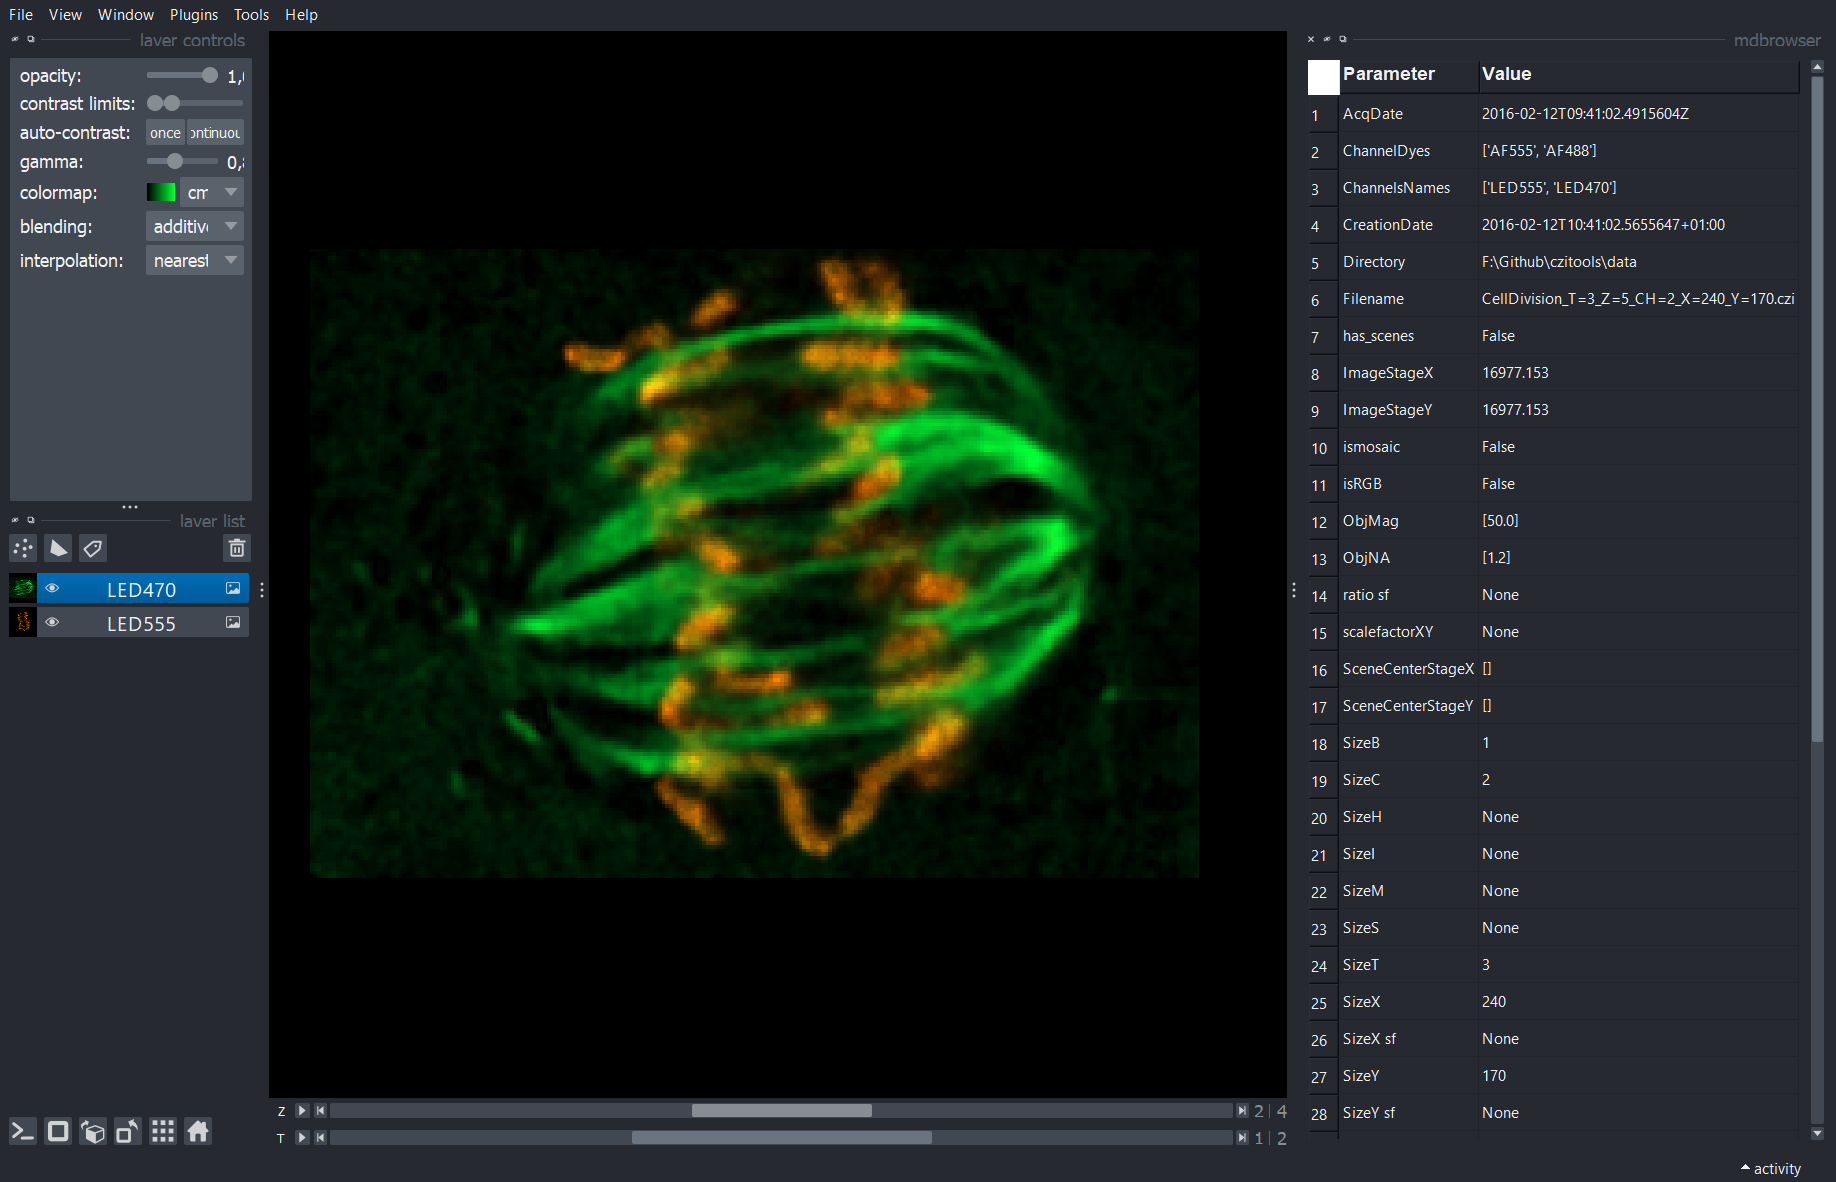

In [8]:
napari.utils.nbscreenshot(viewer)